In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

import glob

In [3]:
PATH = "data/dogscats/"
sz=224
train_path = PATH + '/train'
val_path = PATH + '/valid'

In [4]:
os.listdir(PATH)

['sample', 'test1', 'tmp', 'models', '.ipynb_checkpoints', 'valid', 'train']

In [5]:
os.listdir(PATH + 'valid')

['monkeys', 'dogs', 'cats']

In [6]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="7"

In [7]:
cuda.set_device(7)

In [8]:
torch.cuda.is_available()

True

In [9]:
torch.backends.cudnn.enabled

True

In [10]:
def get_nrof_images_of_classes(path):
    dic = {}
    class_names = [os.path.basename(x) for x in glob.glob(path + '/*')]
    for class_name in class_names:
        dic[class_name] = len(glob.glob(path + '/' + class_name + '/*'))
    return dic

In [11]:
def plot_nrof_images_histogram(path):
    nrof_images_of_train_classes = get_nrof_images_of_classes(path)
    values = nrof_images_of_train_classes.values()
    f = plt.figure(figsize=(20,5))
    plt.bar(range(len(values)), values)
    plt.show()

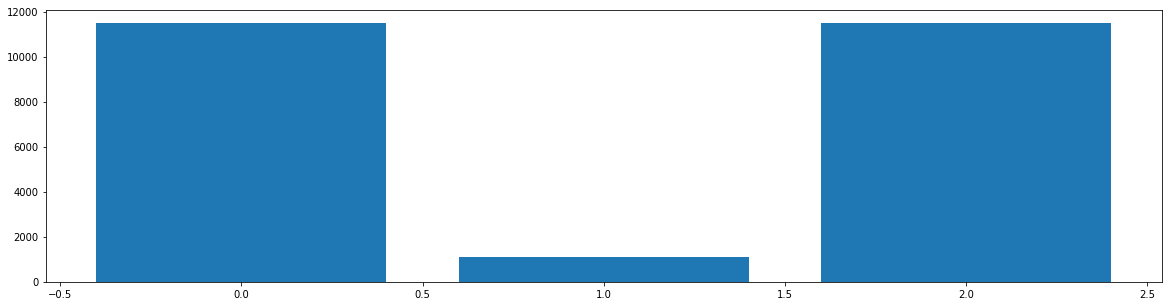

In [12]:
plot_nrof_images_histogram(train_path)

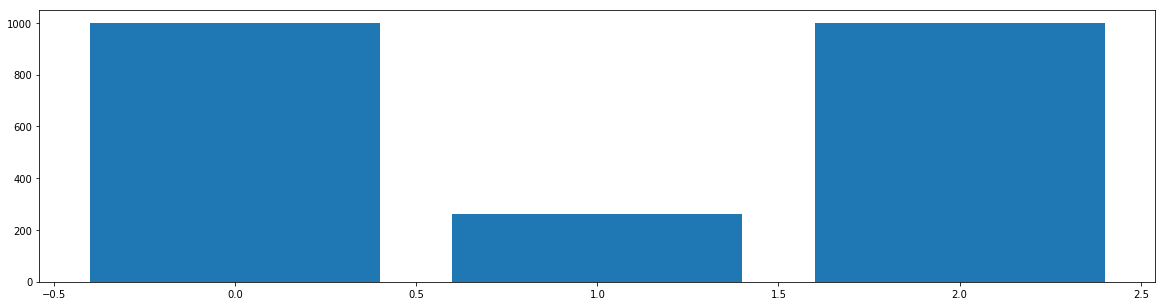

In [13]:
plot_nrof_images_histogram(val_path)

In [14]:
model = resnet34

In [15]:
tfms = tfms_from_model(model, sz)

In [16]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)

In [17]:
learner = ConvLearner.pretrained(model, data, precompute=True)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:01<00:00, 54284243.34it/s]


In [18]:
lrs = learner.lr_find()

 82%|████████▏ | 311/377 [00:03<00:00, 77.91it/s, loss=0.244]


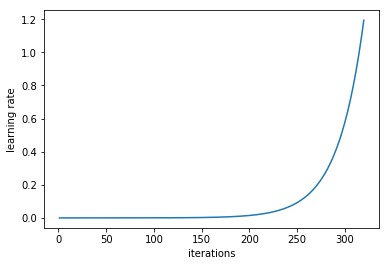

In [19]:
learner.sched.plot_lr()

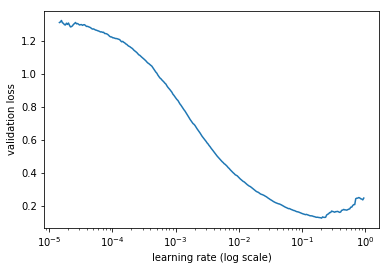

In [20]:
learner.sched.plot()

In [21]:
learner.fit(lrs=0.01 ,n_cycle=1)

epoch      trn_loss   val_loss   accuracy                     
    0      0.05055    0.025976   0.990708  



[0.025975681604009815, 0.9907079646017699]

In [22]:
preds = np.argmax(learner.predict(), axis=1)
accuracy = len(np.where((preds==data.val_ds.y)==True)[0]) / len(data.val_ds.y)
accuracy

0.9907079646017699

In [23]:
def plots(ims, figsize=(20,20), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    num_in_figure = len(ims) // rows * rows
    num_row = rows
    if num_in_figure < len(ims):
        num_row += 1
    for i in range(num_in_figure):
        sp = f.add_subplot(num_row, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

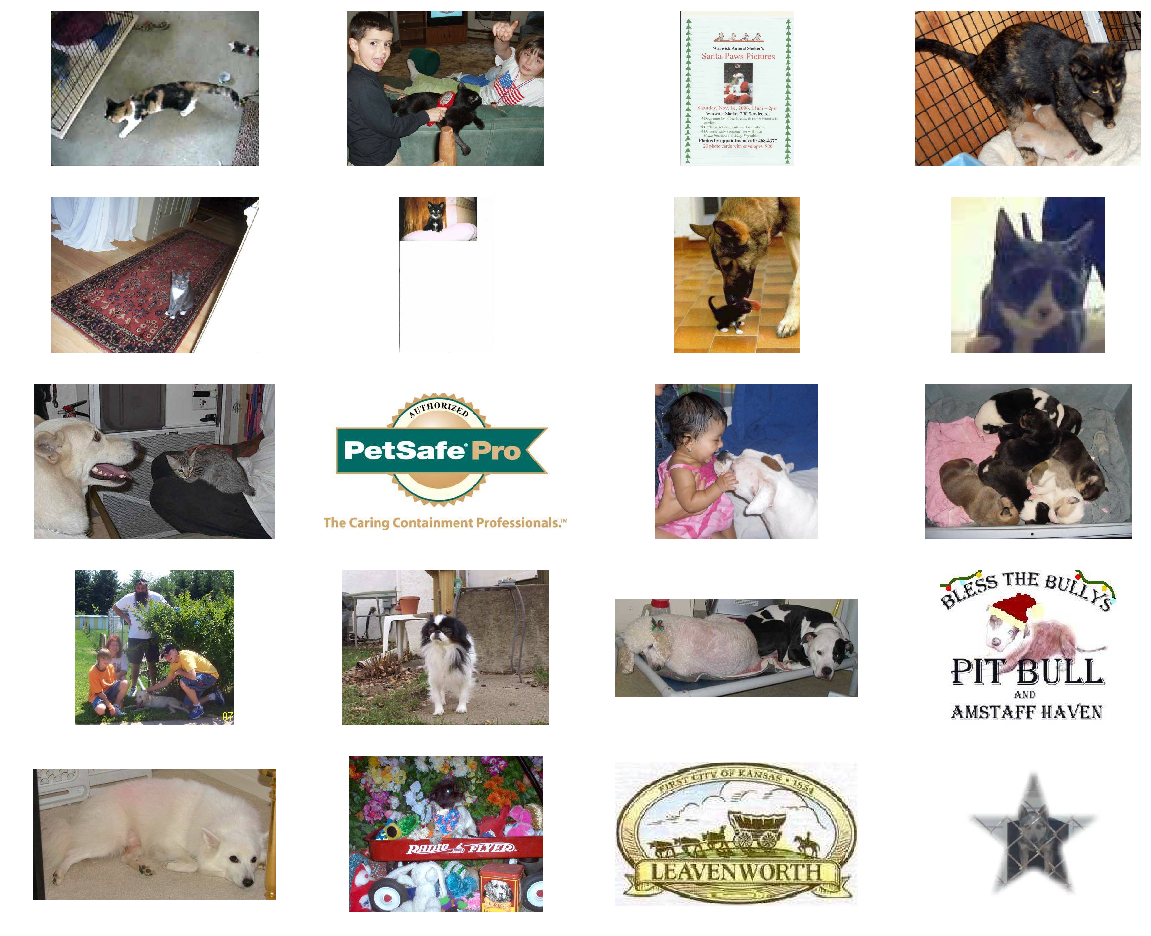

In [24]:
false_classify = np.where((preds==data.val_ds.y)==False)[0]
false_classify_images = [data.val_ds.get_x(ids) for ids in false_classify]
plots(false_classify_images, rows=5)

In [25]:
for i in range(len(false_classify)):
    print('Test image ', false_classify[i], ': Actual class: ',data.classes[data.val_ds.y[false_classify[i]]], '- Predict class: ', data.classes[preds[false_classify[i]]])

Test image  66 : Actual class:  cats - Predict class:  dogs
Test image  82 : Actual class:  cats - Predict class:  dogs
Test image  110 : Actual class:  cats - Predict class:  dogs
Test image  494 : Actual class:  cats - Predict class:  dogs
Test image  555 : Actual class:  cats - Predict class:  dogs
Test image  648 : Actual class:  cats - Predict class:  dogs
Test image  762 : Actual class:  cats - Predict class:  dogs
Test image  805 : Actual class:  cats - Predict class:  dogs
Test image  838 : Actual class:  cats - Predict class:  dogs
Test image  991 : Actual class:  cats - Predict class:  dogs
Test image  1137 : Actual class:  dogs - Predict class:  cats
Test image  1161 : Actual class:  dogs - Predict class:  cats
Test image  1365 : Actual class:  dogs - Predict class:  monkeys
Test image  1391 : Actual class:  dogs - Predict class:  cats
Test image  1408 : Actual class:  dogs - Predict class:  cats
Test image  1580 : Actual class:  dogs - Predict class:  cats
Test image  1588 

In [26]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1, val_name='valid')
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [27]:
ims = np.stack([get_augs() for i in range(6)])

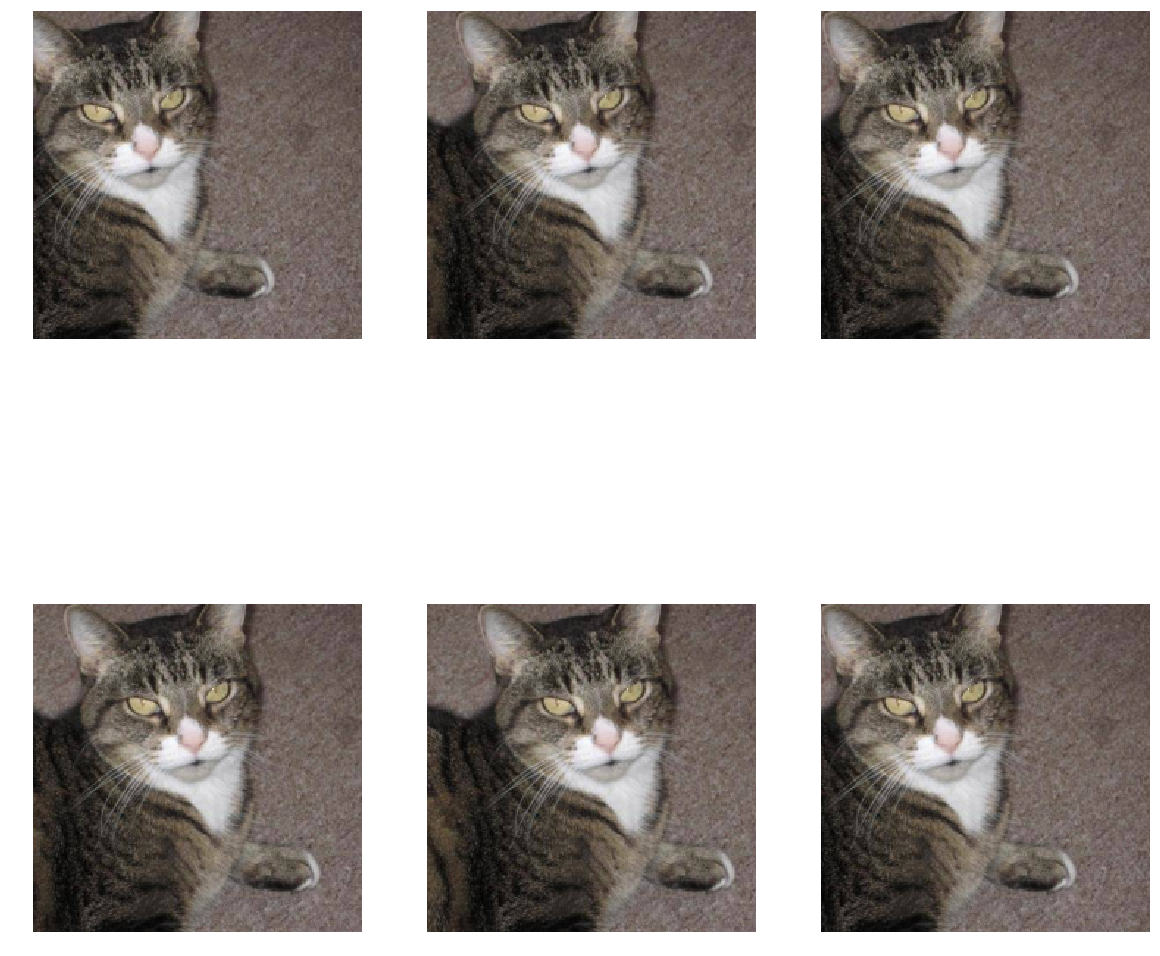

In [28]:
plots(ims, rows=2)

In [29]:
learner.precompute=False

In [30]:
learner.fit( 0.01, n_cycle=3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                     
    0      0.056912   0.025524   0.990708  
    1      0.051866   0.024001   0.99115                      
    2      0.03649    0.024363   0.99115                      



[0.024362966230353424, 0.9911504424778761]

In [31]:
preds = np.argmax(learner.predict(), axis=1)
acc = len(np.where((preds==data.val_ds.y)==True)[0]) / len(data.val_ds.y)
acc

0.9911504424778761

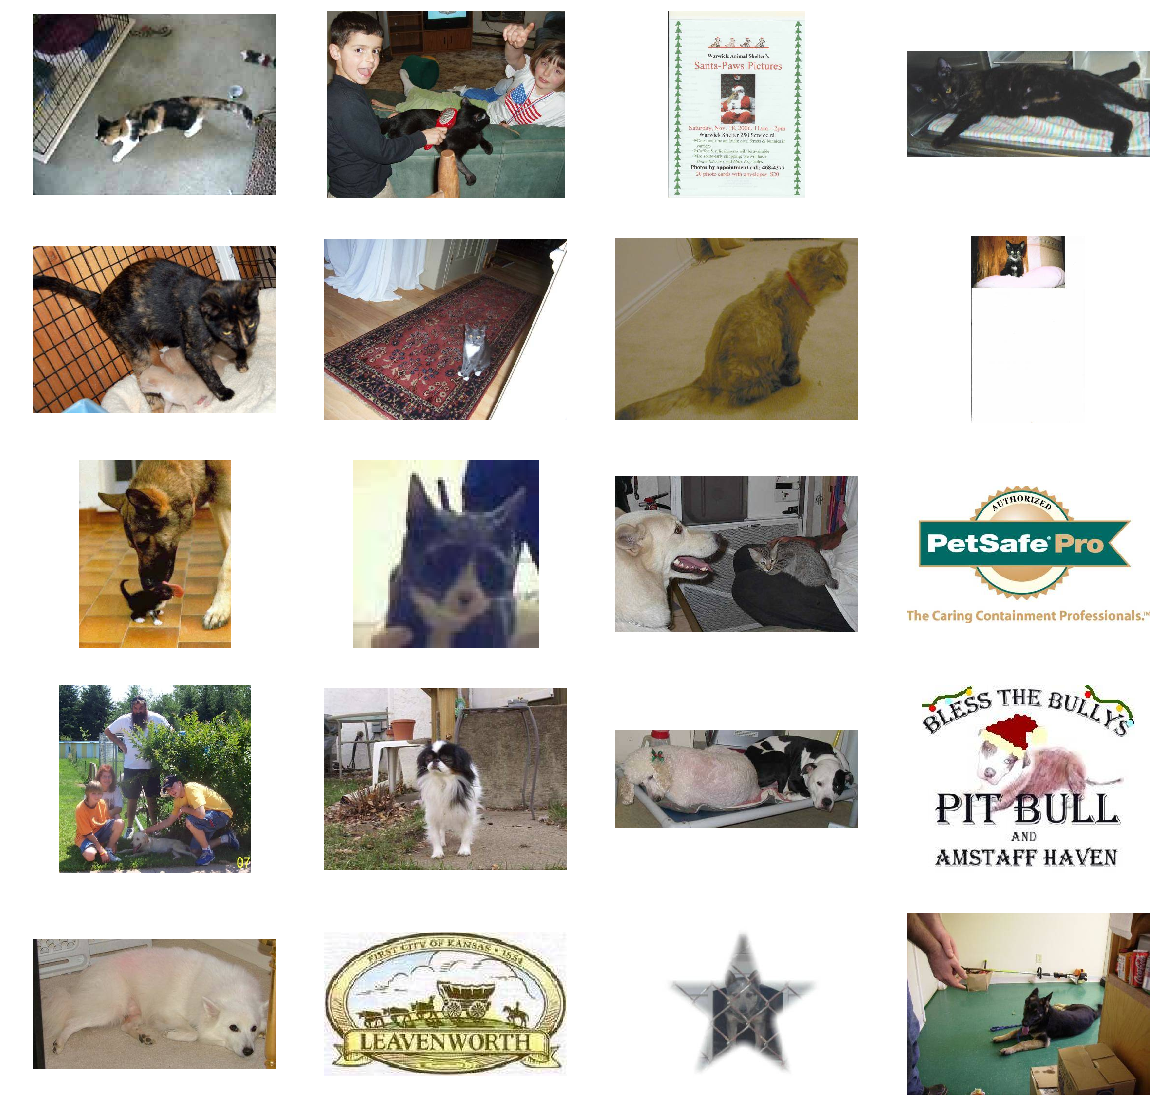

In [32]:
false_classify = np.where((preds==data.val_ds.y)==False)[0]
false_classify_images = [data.val_ds.get_x(ids) for ids in false_classify]
plots(false_classify_images, rows=5)

In [33]:
learner.unfreeze()

In [34]:
lr = 0.01
lrs=np.array([lr/500, lr/50, lr])

In [35]:
learner.fit(lrs=lrs, n_cycle=2, cycle_len=2, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                     
    0      0.060612   0.034177   0.987168  
    1      0.049463   0.033002   0.987168                     
    2      0.039772   0.023974   0.99115                      
    3      0.037237   0.02294    0.992478                     
    4      0.032481   0.023888   0.992035                     
    5      0.037303   0.024219   0.990708                     



[0.02421929157149475, 0.990707964496275]

In [36]:
preds = np.argmax(learner.predict(), axis=1)
acc = len(np.where((preds==data.val_ds.y)==True)[0]) / len(data.val_ds.y); 
acc

0.9907079646017699

In [37]:
false_classify = np.where((preds==data.val_ds.y)==False)[0]
false_classify_images = [data.val_ds.get_x(ids) for ids in false_classify]

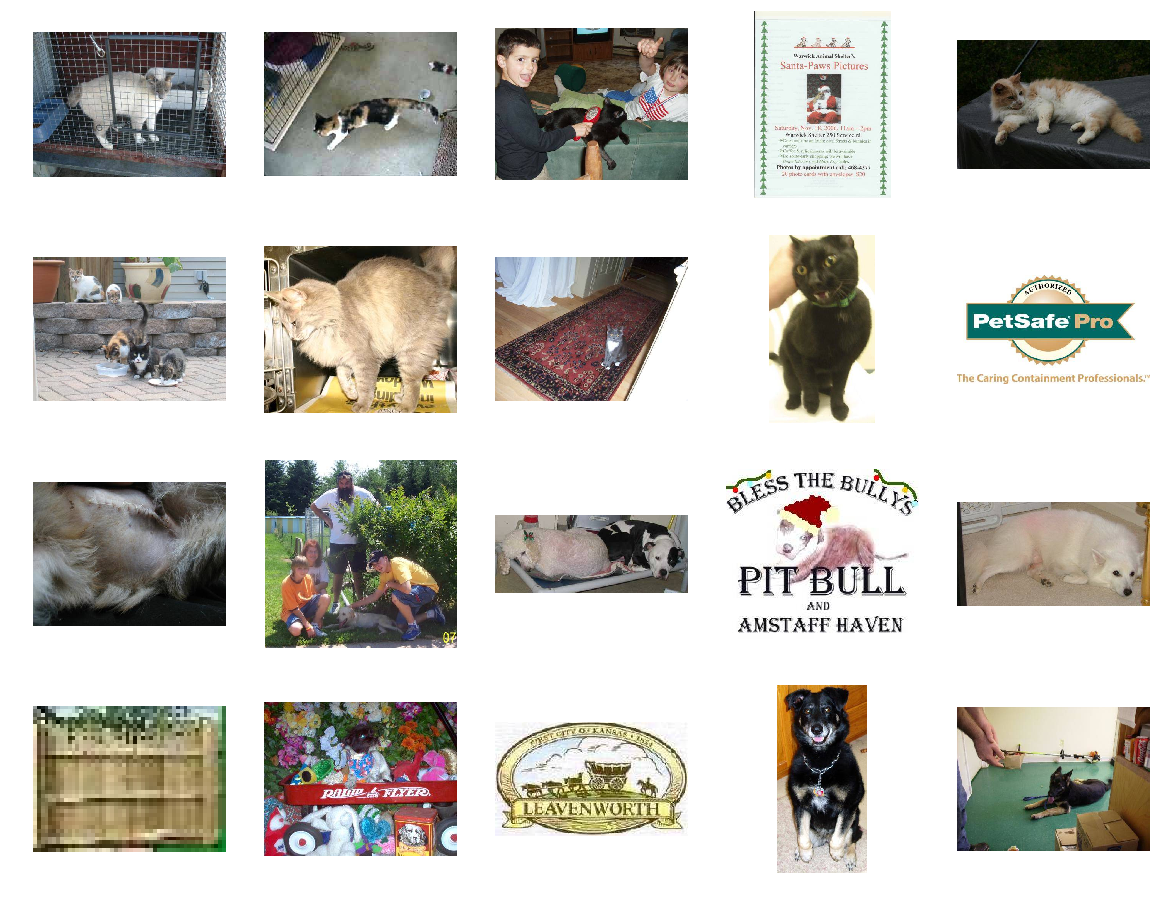

In [38]:
plots(false_classify_images, rows=4)

In [39]:
for i in range(len(false_classify)):
    print('Test image ', false_classify[i], ': Actual class: ',data.classes[data.val_ds.y[false_classify[i]]], '- Predict class: ', data.classes[preds[false_classify[i]]])

Test image  24 : Actual class:  cats - Predict class:  dogs
Test image  66 : Actual class:  cats - Predict class:  dogs
Test image  82 : Actual class:  cats - Predict class:  dogs
Test image  110 : Actual class:  cats - Predict class:  dogs
Test image  161 : Actual class:  cats - Predict class:  dogs
Test image  167 : Actual class:  cats - Predict class:  dogs
Test image  236 : Actual class:  cats - Predict class:  dogs
Test image  555 : Actual class:  cats - Predict class:  dogs
Test image  576 : Actual class:  cats - Predict class:  dogs
Test image  991 : Actual class:  cats - Predict class:  dogs
Test image  1002 : Actual class:  dogs - Predict class:  cats
Test image  1365 : Actual class:  dogs - Predict class:  monkeys
Test image  1408 : Actual class:  dogs - Predict class:  cats
Test image  1580 : Actual class:  dogs - Predict class:  cats
Test image  1588 : Actual class:  dogs - Predict class:  cats
Test image  1675 : Actual class:  dogs - Predict class:  cats
Test image  1678 :

In [40]:
import matplotlib.image as mpimg

In [41]:
def plot_actual_image_vs_predict_class(image_num):
    fig, axes = plt.subplots(nrows=1, ncols=2)
    axes[0].imshow(data.val_ds.get_x(image_num))
    axes[0].set(title='Actual image')
    predict_class_sample_image = random.choice(glob.glob(train_path + '/' + data.classes[preds[image_num]] + '/*'))
    img = mpimg.imread(predict_class_sample_image)
    axes[1].imshow(img)
    axes[1].set(title='Predict class')
    plt.show()

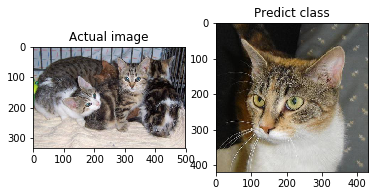

In [42]:
i = np.random.randint(len(false_classify))
plot_actual_image_vs_predict_class(i)

In [43]:
learner.lr_find()

 55%|█████▍    | 206/377 [01:27<01:12,  2.37it/s, loss=0.0628]

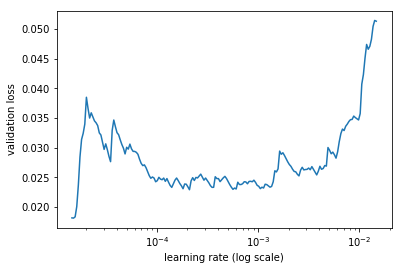

In [44]:
learner.sched.plot()

In [45]:
learner.fit(lrs=0.005, n_cycle=2, cycle_len=2, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                     
    0      0.037936   0.028034   0.989381  
    1      0.017155   0.019014   0.992035                     
    2      0.018471   0.025702   0.989823                     
    3      0.015372   0.021018   0.99115                      
    4      0.008619   0.024244   0.992035                      
    5      0.00617    0.022087   0.992035                      


[0.022086772454420384, 0.9920353982300885]

In [46]:
preds = np.argmax(learner.predict(), axis=1)
acc = len(np.where((preds==data.val_ds.y)==True)[0]) / len(data.val_ds.y); acc

0.9920353982300885

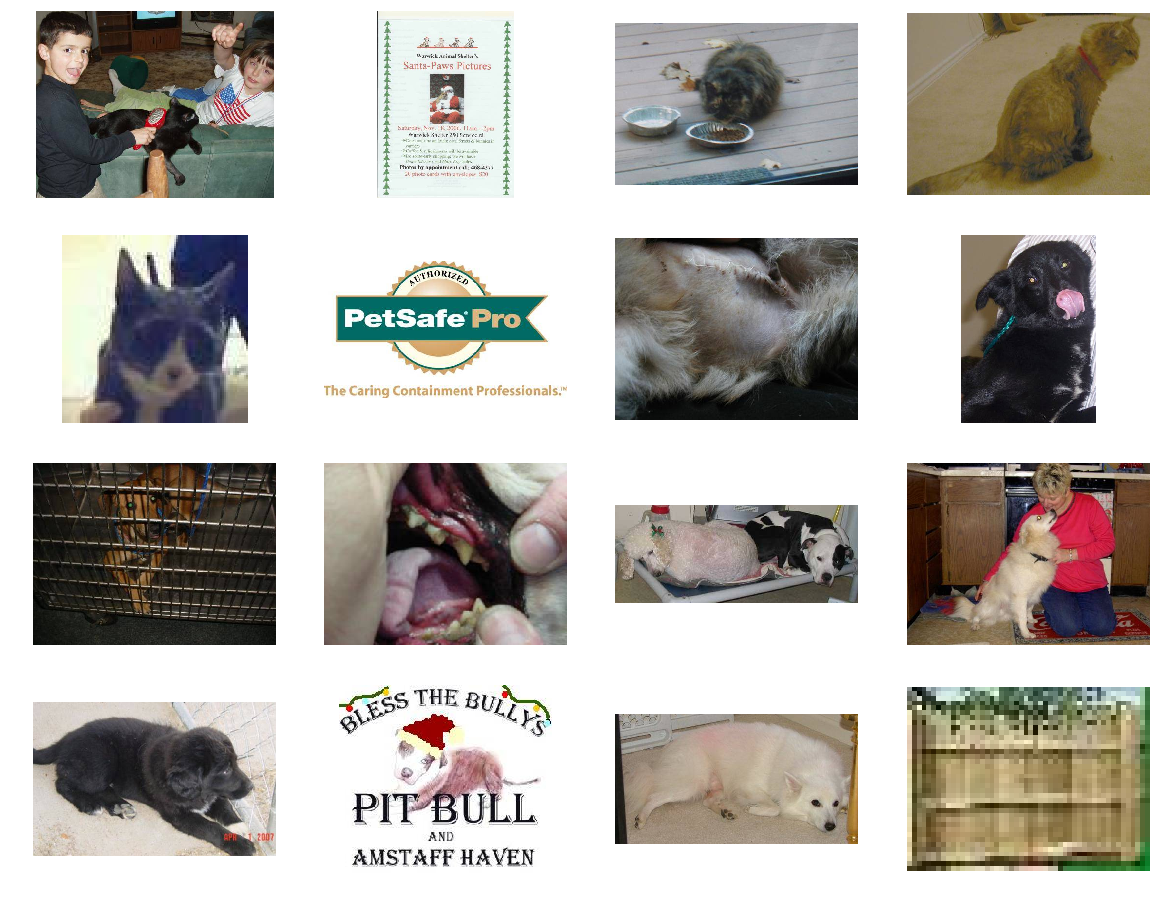

In [49]:
false_classify = np.where((preds==data.val_ds.y)==False)[0]
false_classify_images = [data.val_ds.get_x(ids) for ids in false_classify]
plots(false_classify_images, rows=4)

In [50]:
for i in range(len(false_classify)):
    print('Test image ', false_classify[i], ': Actual class: ',data.classes[data.val_ds.y[false_classify[i]]], '- Predict class: ', data.classes[preds[false_classify[i]]])

Test image  82 : Actual class:  cats - Predict class:  dogs
Test image  110 : Actual class:  cats - Predict class:  dogs
Test image  451 : Actual class:  cats - Predict class:  dogs
Test image  625 : Actual class:  cats - Predict class:  dogs
Test image  805 : Actual class:  cats - Predict class:  dogs
Test image  991 : Actual class:  cats - Predict class:  dogs
Test image  1002 : Actual class:  dogs - Predict class:  cats
Test image  1024 : Actual class:  dogs - Predict class:  cats
Test image  1303 : Actual class:  dogs - Predict class:  cats
Test image  1318 : Actual class:  dogs - Predict class:  cats
Test image  1408 : Actual class:  dogs - Predict class:  cats
Test image  1483 : Actual class:  dogs - Predict class:  cats
Test image  1488 : Actual class:  dogs - Predict class:  cats
Test image  1580 : Actual class:  dogs - Predict class:  cats
Test image  1588 : Actual class:  dogs - Predict class:  cats
Test image  1675 : Actual class:  dogs - Predict class:  cats
Test image  167

In [51]:
preds_tta, y = learner.TTA()

In [52]:
preds = np.argmax(np.mean(preds_tta, 0), axis=1)

In [53]:
acc = len(np.where((preds==data.val_ds.y)==True)[0]) / len(data.val_ds.y); acc

0.9929203539823008

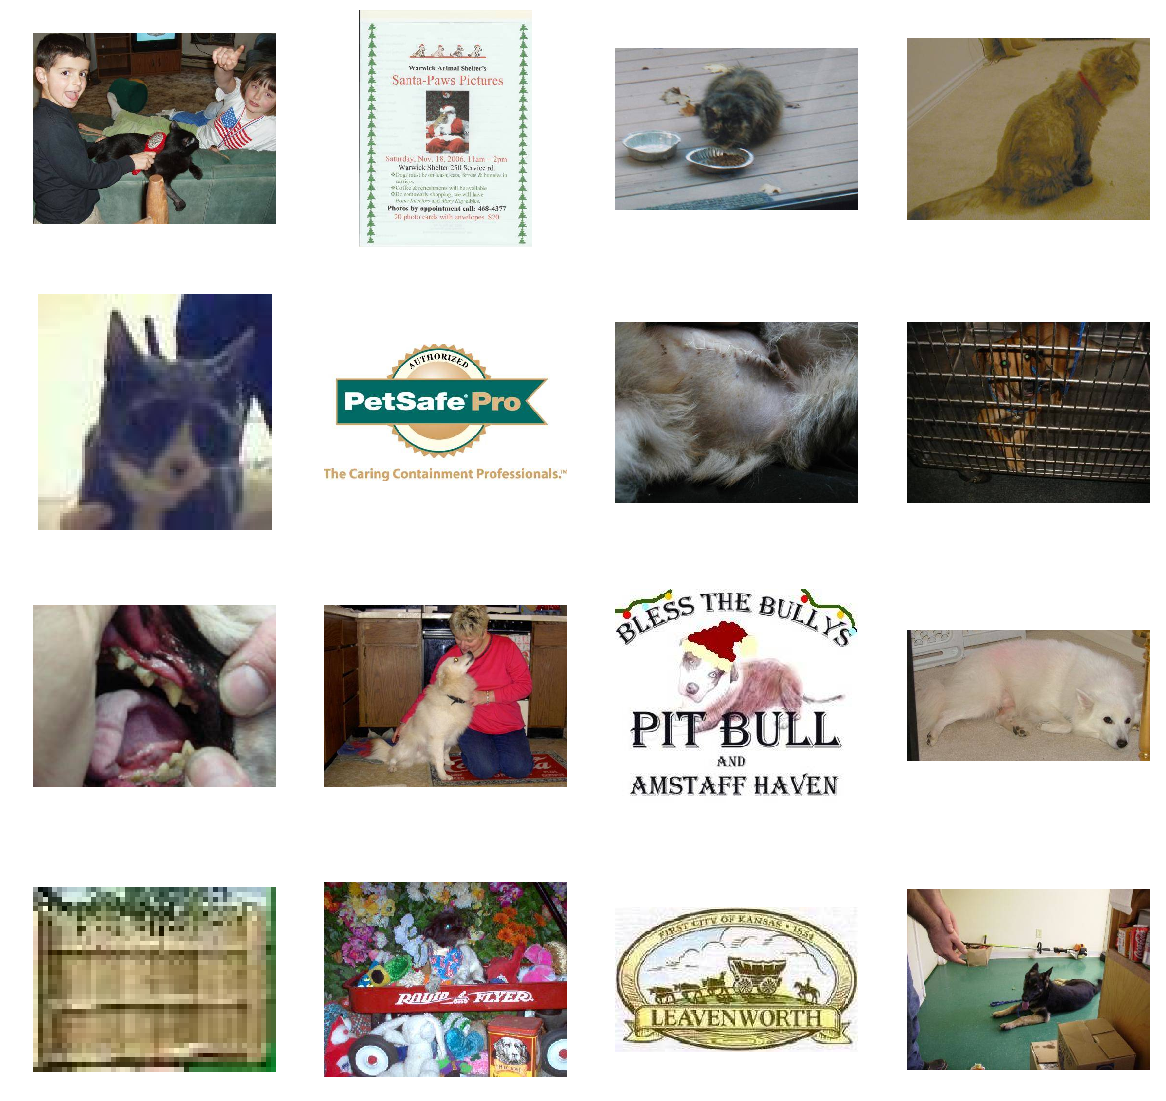

In [55]:
false_classify = np.where((preds==data.val_ds.y)==False)[0]
false_classify_images = [data.val_ds.get_x(ids) for ids in false_classify]
plots(false_classify_images, rows=4)

In [56]:
for i in range(len(false_classify)):
    print('Test image ', false_classify[i], ': Actual class: ',data.classes[data.val_ds.y[false_classify[i]]], '- Predict class: ', data.classes[preds[false_classify[i]]])

Test image  82 : Actual class:  cats - Predict class:  dogs
Test image  110 : Actual class:  cats - Predict class:  dogs
Test image  451 : Actual class:  cats - Predict class:  dogs
Test image  625 : Actual class:  cats - Predict class:  dogs
Test image  805 : Actual class:  cats - Predict class:  dogs
Test image  991 : Actual class:  cats - Predict class:  dogs
Test image  1002 : Actual class:  dogs - Predict class:  cats
Test image  1303 : Actual class:  dogs - Predict class:  cats
Test image  1318 : Actual class:  dogs - Predict class:  cats
Test image  1483 : Actual class:  dogs - Predict class:  cats
Test image  1580 : Actual class:  dogs - Predict class:  cats
Test image  1588 : Actual class:  dogs - Predict class:  cats
Test image  1675 : Actual class:  dogs - Predict class:  cats
Test image  1678 : Actual class:  dogs - Predict class:  cats
Test image  1765 : Actual class:  dogs - Predict class:  cats
Test image  1900 : Actual class:  dogs - Predict class:  cats


In [57]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[994   6   0]
 [ 10 990   0]
 [  0   0 260]]


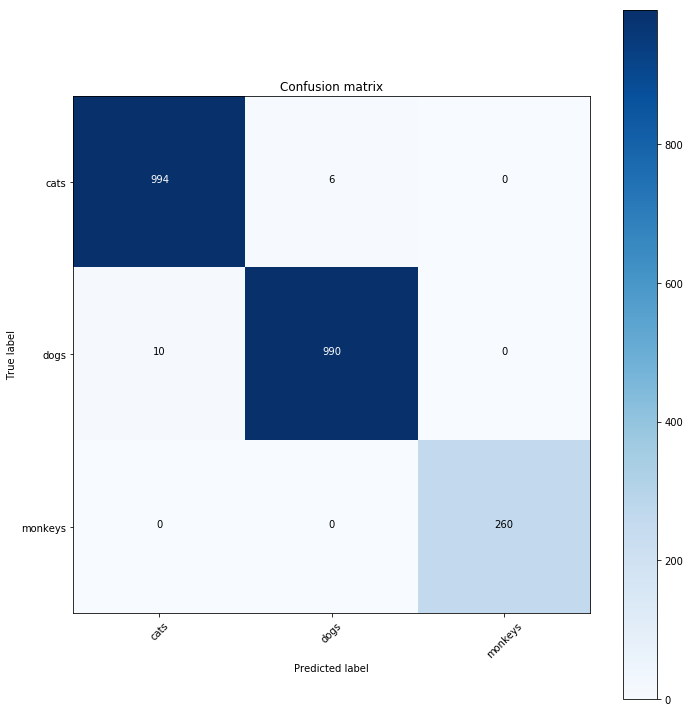

In [59]:
plot_confusion_matrix(cm, data.classes, figsize=(10,10))